## Analizar la metricas de rendimientos

In [1]:
import torch
# Mi libreria:
%load_ext autoreload
%autoreload 2
from processLIDC import Patient
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [23]:
def get_confusion_matrix(id_patient, model, threshold = 0.5, batch = 10):
    cm = np.zeros((2,2))
    print(cm)
    patient = Patient("LIDC-IDRI-0002")
    patient.scale()
    images, mask = patient.get_tensors(scaled = False)
    mask = mask.cpu().detach().numpy()
    n_slices = mask.shape[0]
    for i in tqdm(range(0, n_slices, batch)):
        if i <160 or i>190:
            continue
        slices = (i, i+batch)
        pred = patient.predict(model, slices=slices, scaled=True, gpu = True)
        pred_bin = np.where(pred >= threshold, 1, 0)
        prediccion = pred_bin[:,0].flatten()
        
        # Utilizando la función ravel()
        label = mask[slices[0]:slices[-1]].flatten()
        cm_ = confusion_matrix(label, prediccion, labels=(0,1))
        cm = cm + np.array(cm_)
        
    
    print('terminado')
    return cm

In [73]:
def get_confusion_matrix2(id_patient, model, threshold = 0.5, batch = 10):
    cm = np.zeros((2,2))
    print(cm)
    patient = Patient(id_patient)
    patient.scale()
    images, mask = patient.get_tensors(scaled = False)
    mask = mask.cpu().detach().numpy()
    n_slices = mask.shape[0]
    slices = (0, batch)
    prediccion = patient.predict(model, slices=slices, scaled=True, gpu = True)
    prediccion = np.where(prediccion >= threshold, 1, 0)[:,0,:,:]
    
    print(prediccion.shape)
    _ = []
    
    for i in tqdm(range(batch, n_slices, batch)):
        
        if i <70 or i>90:
            continue
        
        slices = (i, i+batch)
        pred = patient.predict(model, slices=slices, scaled=True, gpu = True)
        pred_bin = np.where(pred >= threshold, 1, 0)[:,0,:,:]
        prediccion = np.concatenate((prediccion, pred_bin), axis=0)
        
        print(prediccion.shape)
        # Utilizando la función ravel()
        _.append(i)
        _.append(i+batch)
        print(i+batch)
        
    
    print(mask[_[0]:_[0]+prediccion.shape[0]].shape)
    print(prediccion.shape)
    
    
    label = mask[_[0]:_[0]+prediccion.shape[0]].flatten()
    # label = mask.flatten()
    
    prediccion = prediccion.flatten()
    cm_ = confusion_matrix(label, prediccion, labels=(0,1))
    cm = cm + np.array(cm_)
    
    print('terminado')
    return cm

In [71]:
def get_confusion_matrix3(id_patient, model, threshold = 0.5, batch = 10):
    cm = np.zeros((2,2))
    if isinstance(id_patient,str):
        cm = get_confusion_matrix2(id_patient, model, threshold =threshold, batch = batch)
        return cm
    else:
        cm = get_confusion_matrix2(id_patient[0], model, threshold =threshold, batch = batch)
        for id in tqdm(id_patient[1:]):
            cm = cm + get_confusion_matrix2(id, model, threshold =threshold, batch = batch)
        return cm


In [ ]:
patient = Patient("LIDC-IDRI-0002")
patient.scale()

In [3]:
model = torch.jit.load('model_scripted.pt')
model.to('cuda')
model.eval()

RecursiveScriptModule(
  original_name=UNet
  (encoder1): RecursiveScriptModule(
    original_name=Sequential
    (enc1conv1): RecursiveScriptModule(original_name=Conv2d)
    (enc1norm1): RecursiveScriptModule(original_name=BatchNorm2d)
    (enc1relu1): RecursiveScriptModule(original_name=ReLU)
    (enc1conv2): RecursiveScriptModule(original_name=Conv2d)
    (enc1norm2): RecursiveScriptModule(original_name=BatchNorm2d)
    (enc1relu2): RecursiveScriptModule(original_name=ReLU)
  )
  (pool1): RecursiveScriptModule(original_name=MaxPool2d)
  (encoder2): RecursiveScriptModule(
    original_name=Sequential
    (enc2conv1): RecursiveScriptModule(original_name=Conv2d)
    (enc2norm1): RecursiveScriptModule(original_name=BatchNorm2d)
    (enc2relu1): RecursiveScriptModule(original_name=ReLU)
    (enc2conv2): RecursiveScriptModule(original_name=Conv2d)
    (enc2norm2): RecursiveScriptModule(original_name=BatchNorm2d)
    (enc2relu2): RecursiveScriptModule(original_name=ReLU)
  )
  (pool2): Rec

In [ ]:
slices = (176, 183)
pred = patient.predict(model, slices=slices, scaled=True, gpu = True)
images, mask = patient.get_tensors(scaled = False)
mask = mask.cpu().detach().numpy()

thres = 0.5
pred_bin = np.where(pred >= thres, 1, 0)

In [ ]:
print(pred.shape)
print(pred_bin.shape)
print(mask.shape)
print(np.max(pred_bin), np.max(mask))

# plt.imshow(mask[176])
# plt.show()
# plt.imshow(pred_bin[0,0])
# plt.show()

In [ ]:

prediccion = pred_bin[:,0].flatten()

# # Utilizando la función ravel()
label = mask[slices[0]:slices[-1]].flatten()

print(prediccion.shape)
print(label.shape)
cm = confusion_matrix(label, prediccion)

# Etiquetas de las clases
# labels = np.unique(mask)

# Crear figura y ejes
fig, ax = plt.subplots()

# Crear mapa de calor utilizando seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)  # , xticklabels=labels, yticklabels=labels)

# Añadir etiquetas a los ejes
ax.set_xlabel("Etiqueta Predicha")
ax.set_ylabel("Etiqueta Verdadera")

# Añadir título
ax.set_title("Matriz de Confusión")

# Mostrar la figura
plt.show()

In [74]:
cm = get_confusion_matrix3(["LIDC-IDRI-0002","LIDC-IDRI-0013"], model, threshold=0.3, batch = 3)

[[0. 0.]
 [0. 0.]]
(3, 256, 256)


 28%|██▊       | 24/86 [00:01<00:03, 17.77it/s]

(6, 256, 256)
75
(9, 256, 256)
78


 30%|███       | 26/86 [00:03<00:11,  5.25it/s]

(12, 256, 256)
81


 31%|███▏      | 27/86 [00:05<00:15,  3.70it/s]

(15, 256, 256)
84


 33%|███▎      | 28/86 [00:06<00:21,  2.72it/s]

(18, 256, 256)
87


 34%|███▎      | 29/86 [00:08<00:27,  2.05it/s]

(21, 256, 256)
90


100%|██████████| 86/86 [00:09<00:00,  9.15it/s]

(24, 256, 256)
93
(24, 256, 256)
(24, 256, 256)


terminado


  0%|          | 0/1 [00:00<?, ?it/s]

[[0. 0.]
 [0. 0.]]
(3, 256, 256)


(6, 256, 256)
75
(9, 256, 256)
78
(12, 256, 256)
81
(15, 256, 256)
84


(18, 256, 256)
87
(21, 256, 256)
90


100%|██████████| 41/41 [00:04<00:00,  9.21it/s]

(24, 256, 256)
93
(24, 256, 256)
(24, 256, 256)



100%|██████████| 1/1 [00:07<00:00,  7.85s/it]

terminado


In [75]:
np.array(cm).shape
cm

array([[3.144245e+06, 9.100000e+02],
       [5.730000e+02, 0.000000e+00]])

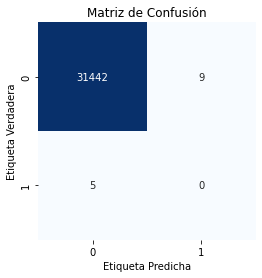

In [76]:
fig, ax = plt.subplots()

# Crear mapa de calor utilizando seaborn
sns.heatmap(np.int32(cm/100), annot=True, fmt="d", cmap="Blues", cbar=False, square=True)  # , xticklabels=labels, yticklabels=labels)

# Añadir etiquetas a los ejes
ax.set_xlabel("Etiqueta Predicha")
ax.set_ylabel("Etiqueta Verdadera")

# Añadir título
ax.set_title("Matriz de Confusión")

# Mostrar la figura
plt.show()